In [3]:
import pandas as pd

In [4]:
coso = pd.read_csv('coso.csv')
new0 = pd.read_csv('New_DB_new0.csv')

In [5]:
new0 = new0[['PP', 'slope', 'valor_humedad_suelo1', 'Latitud', 'Longitud']].dropna()
coso = coso[['PP', 'slope', 'valor_humedad_suelo1', 'Latitud', 'Longitud']].dropna()

In [6]:
data_0 = pd.read_csv('xterrae_data_0').dropna()
data_1 = pd.read_csv('xterrae_data_1').dropna()

In [7]:
new0

,PP,slope,valor_humedad_suelo1,Latitud,Longitud
0,71.563169,23.981049,0.438995,-39.597580,-72.260578
1,71.563169,26.626618,0.438995,-39.598738,-72.254661
2,71.563169,28.545852,0.438995,-39.582146,-72.258995
3,71.563169,28.545852,0.438995,-39.580483,-72.272591
4,7.532796,35.594937,0.438187,-39.561471,-72.286932
...,...,...,...,...,...
1355,1.167900,45.373746,0.352768,-39.615112,-73.198518
1356,1.054908,28.705555,0.313675,-39.663321,-73.166174
1357,0.000000,35.755171,0.306458,-39.556847,-73.134727
1358,0.000000,40.502730,0.335510,-39.460378,-73.158058


In [8]:
data_0 = pd.merge(new0, data_0, on=['Latitud', 'Longitud'], how='inner')
data_1 = pd.merge(coso, data_1, on=['Latitud', 'Longitud'], how='inner')

In [9]:
data_0 = data_0.drop(columns=['Unnamed: 0', 'Latitud', 'Longitud'])
data_1 = data_1.drop(columns=['Unnamed: 0', 'Latitud', 'Longitud'])
data_0['Valor'] = 0
data_1['Valor'] = 1

In [10]:
final_db = pd.read_csv('final_db.csv')
final_db = final_db.drop(columns='Unnamed: 0')

In [11]:
def comparar_columnas(df1, df2):
    # Obtener los nombres de las columnas en cada DataFrame
    columnas_df1 = set(df1.columns)
    columnas_df2 = set(df2.columns)
    
    # Encontrar columnas que están en df1 pero no en df2
    solo_en_df1 = columnas_df1 - columnas_df2
    
    # Encontrar columnas que están en df2 pero no en df1
    solo_en_df2 = columnas_df2 - columnas_df1
    
    # Imprimir los resultados
    if solo_en_df1:
        print("Columnas en df1 pero no en df2:")
        for columna in solo_en_df1:
            print(columna)
    else:
        print("Todas las columnas de df1 están en df2.")
    
    if solo_en_df2:
        print("Columnas en df2 pero no en df1:")
        for columna in solo_en_df2:
            print(columna)
    else:
        print("Todas las columnas de df2 están en df1.")

In [12]:
comparar_columnas(final_db,data_0)

Todas las columnas de df1 están en df2.
Todas las columnas de df2 están en df1.


In [13]:
comparar_columnas(final_db,data_1)

Todas las columnas de df1 están en df2.
Todas las columnas de df2 están en df1.


In [14]:
final = pd.concat([final_db, data_0])
final = pd.concat([final, data_1])

In [15]:
final = final.dropna()

In [16]:
final_x = final.drop(columns='Valor')
final_y = final.Valor

In [17]:
import pandas as pd
import numpy as np

def eliminar_caracteristicas(df, umbral):
    """
    Elimina características de un DataFrame basado en la correlación.
    
    Args:
    - df (pd.DataFrame): DataFrame con las características.
    - umbral (float): Umbral de correlación para eliminar características.
    
    Returns:
    - pd.DataFrame: DataFrame con las características restantes.
    - int: Número de características eliminadas.
    """
    # Calcular la matriz de correlación
    correlaciones = df.corr().abs()
    
    # Crear una máscara para evitar considerar la diagonal principal
    mask = np.triu(np.ones_like(correlaciones, dtype=bool), k=1)
    
    # Identificar pares de características con alta correlación
    to_drop = set()
    for i in range(len(correlaciones.columns)):
        for j in range(i):
            if correlaciones.iloc[i, j] > umbral:
                colname = correlaciones.columns[i]
                to_drop.add(colname)
    
    # Eliminar las características
    df_reducido = df.drop(columns=to_drop)
    
    # Número de características eliminadas
    num_eliminadas = len(to_drop)
    
    return df_reducido, num_eliminadas

def prueba_umbral(df, umbrales):
    """
    Prueba diferentes umbrales y guarda el número de características eliminadas.
    
    Args:
    - df (pd.DataFrame): DataFrame con las características.
    - umbrales (list): Lista de umbrales para probar.
    
    Returns:
    - pd.DataFrame: DataFrame con los resultados de la prueba.
    """
    resultados = []
    
    for umbral in umbrales:
        df_reducido, num_eliminadas = eliminar_caracteristicas(df, umbral)
        resultados.append({'Umbral': umbral, 'Caracteristicas eliminadas': num_eliminadas})
    
    return pd.DataFrame(resultados)

# Ejemplo de uso:
# df = pd.DataFrame(...)  # Reemplaza con tu DataFrame real
umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
resultados = prueba_umbral(final, umbrales)

print(resultados)

   Umbral  Caracteristicas eliminadas
0    0.10                         136
1    0.20                         135
2    0.30                         131
3    0.40                         130
4    0.50                         128
5    0.60                         128
6    0.70                         122
7    0.80                         113
8    0.90                          91
9    0.99                          38


In [18]:
df_reducido, num_eliminadas = eliminar_caracteristicas(final, 0.9)

In [19]:
final = df_reducido

In [20]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

def cart_feature_selection(df, target_column, n_features=5):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    cart = RandomForestClassifier(random_state=42)
    #cart = XGBClassifier(random_state=42)
    cart.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': cart.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected_features = feature_importance['feature'][:n_features].tolist()
    
    return selected_features


In [21]:
cart_features = cart_feature_selection(final, 'Valor', n_features=30)
cart_features

['slope',
 'valor_humedad_suelo1',
 'PP',
 'ksat_60-100cm.tif',
 'PIRange_Clay.15-30cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'n_60-100cm.tif',
 'alpha.0-5cm.tif',
 'n_15-30cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'PIRange_Clay.5-15cm.tif',
 'PIRange_Bulkd.5-15cm.tif',
 'PIRange_Bulkd.100-200cm.tif',
 'n_5-15cm.tif',
 'PIRange_Sand.15-30cm.tif',
 'ksat_100-200cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'ksat_15-30cm.tif',
 'ksat_5-15cm.tif',
 'theta_s_5-15cm.tif',
 'theta_s_100-200cm.tif',
 'theta_s_15-30cm.tif',
 'FC.5-15cm.tif',
 'PIRange_Bulkd.0-5cm.tif',
 'AvMoist.0-5cm.tif',
 'ksat_0-5cm.tif',
 'FC.100-200cm.tif',
 'Bulkd.5-15cm.tif',
 'Bulkd.100-200cm.tif',
 'FC.0-5cm.tif']

In [22]:
X = final[cart_features]
y = final.Valor

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (2518, 30), Numero de test: (630, 30)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 85.87301587301587


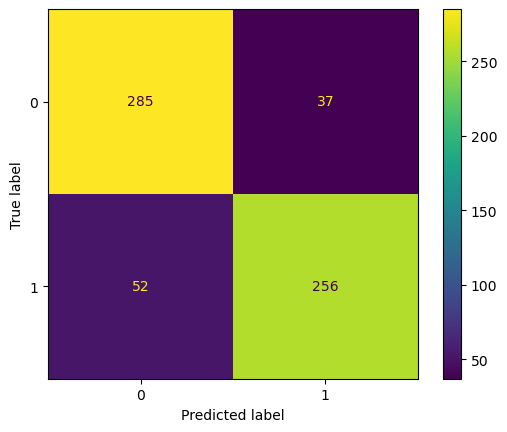

In [24]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
data = final[cart_features]
data['Valor'] = final.Valor
data_aux_1 = data[data.Valor == 1]
data_aux_0 = data[data.Valor == 0]
data_aux_0 = data_aux_0.drop(columns='Valor')
data_aux_1 = data_aux_1.drop(columns='Valor')

C:\Users\Manuel\AppData\Local\Temp\ipykernel_11936\1511315089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Valor'] = final.Valor


In [26]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class PUBagging:
    def __init__(self, num_iterations=10, sample_ratio=1.0, random_state=42):
        self.num_iterations = num_iterations
        self.sample_ratio = sample_ratio
        self.random_state = random_state
        self.classifiers = []
        self.probabilities = None

    def fit(self, landslide_samples, unlabeled_samples):
        np.random.seed(self.random_state)

        if isinstance(landslide_samples, np.ndarray):
            landslide_samples_array = landslide_samples
        else:
            landslide_samples_array = landslide_samples.values  # Convert to numpy array if it's a DataFrame

        if isinstance(unlabeled_samples, np.ndarray):
            unlabeled_samples_array = unlabeled_samples
        else:
            unlabeled_samples_array = unlabeled_samples.values  # Convert to numpy array if it's a DataFrame

        num_samples = len(landslide_samples_array)
        num_unlabeled = len(unlabeled_samples_array)

        for _ in range(self.num_iterations):
            # Step 1: Sample equal number of unlabeled samples as non-landslide samples
            non_landslide_indices = np.random.choice(num_unlabeled, size=int(num_samples * self.sample_ratio), replace=False)
            non_landslide_samples = unlabeled_samples_array[non_landslide_indices]

            # Combine with landslide samples to form training set
            X_train = np.vstack((landslide_samples_array, non_landslide_samples))
            y_train = np.hstack((np.ones(num_samples), np.zeros(len(non_landslide_samples))))

            # Step 2: Train decision tree classifier
            clf = DecisionTreeClassifier(random_state=self.random_state)
            clf.fit(X_train, y_train)
            self.classifiers.append(clf)

            # Step 3: Predict probability of being landslide for unlabeled samples
            prob_landslide = clf.predict_proba(unlabeled_samples_array)[:, 1]

            if self.probabilities is None:
                self.probabilities = prob_landslide
            else:
                self.probabilities += prob_landslide

        # Step 4: Average probabilities over iterations
        self.probabilities /= self.num_iterations

    def predict_proba(self, unlabeled_samples):
        if isinstance(unlabeled_samples, np.ndarray):
            return self.probabilities
        else:
            return self.probabilities[:len(unlabeled_samples)]  # Return probabilities for original DataFrame

# Example usage:
if __name__ == '__main__':
    import pandas as pd
    
    # Example data (replace with your own data)
    landslide_samples = data_aux_1# Example landslide samples as DataFrame
    unlabeled_samples = data_aux_0# Example unlabeled samples as DataFrame

    # Create PU Bagging instance
    pu_bagging = PUBagging(num_iterations=5, sample_ratio=0.4, random_state=42)

    # Fit the model
    pu_bagging.fit(landslide_samples, unlabeled_samples)

    # Predict probabilities for unlabeled samples
    probabilities = pu_bagging.predict_proba(unlabeled_samples)
    print("Predicted probabilities:", probabilities)

Predicted probabilities: [0.2 0.  0.2 ... 0.6 0.2 0.8]


In [27]:
# Suponiendo que ya tienes las probabilidades predichas por pu_bagging.predict_proba(unlabeled_samples)

# Umbral para seleccionar muestras no deslizamiento
threshold = 0.5  # Puedes ajustar este umbral según tus necesidades

# Filtrar muestras no deslizamiento por debajo del umbral
non_landslide_indices = np.where(probabilities < threshold)[0]
selected_non_landslide_samples = unlabeled_samples.iloc[non_landslide_indices]

# Ejemplo de cómo podrías utilizar las muestras seleccionadas
print("Muestras no deslizamiento seleccionadas:")
print(selected_non_landslide_samples)

Muestras no deslizamiento seleccionadas:
          slope  valor_humedad_suelo1          PP  ksat_60-100cm.tif  \
0     32.357300              0.421875   13.532034         282.394012   
1     32.357300              0.438995  238.139918         282.394012   
2     37.497812              0.520004   32.059045         144.182007   
3     36.717389              0.478973    0.000000          90.413002   
4     60.517945              0.438095    2.191190         343.306000   
...         ...                   ...         ...                ...   
1162  24.327043              0.416611    0.674241         279.865997   
1163  24.327043              0.416611    0.674241         261.084015   
1164  24.641348              0.313675    1.054908         252.315994   
1165  45.373746              0.352768    1.167900         141.238998   
1167  40.502730              0.335510    0.000000         119.821999   

      PIRange_Clay.15-30cm.tif  PIRange_Clay.0-5cm.tif  n_60-100cm.tif  \
0                   

In [28]:
selected_non_landslide_samples['Valor'] = 0
data_aux_1['Valor'] = 1

data = pd.concat([data_aux_1, selected_non_landslide_samples])
data_y = data['Valor']
data = data.drop(columns=['Valor'])

C:\Users\Manuel\AppData\Local\Temp\ipykernel_11936\38701351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_non_landslide_samples['Valor'] = 0


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (2371, 30), Numero de test: (593, 30)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 87.52107925801012


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import creator, base, tools, algorithms

def evaluar_cromosoma(individual, X, y, n_caracteristicas):
    # Decodificar el cromosoma
    selected_features = X.columns[np.array(individual, dtype=bool)]
    
    # Verificar restricciones
    if len(selected_features) == 0:
        return 1,  # Penalización máxima si no se selecciona ninguna característica
    
    # Entrenar el modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')
    
    # Obtener medida de rendimiento (1 - sensibilidad para minimización)
    rendimiento = 1 - np.mean(scores)
    
    # Castigar al cromosoma basado en la cantidad de características
    penalizacion = len(selected_features) / n_caracteristicas
    
    # Devolver el valor de evaluación
    return rendimiento + penalizacion,

def seleccion_caracteristicas_genetico(df, target_column, n_generations=50, population_size=50):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    n_caracteristicas = len(X.columns)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_caracteristicas)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluar_cromosoma, X=X, y=y, n_caracteristicas=n_caracteristicas)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    for gen in range(n_generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.1 + (gen / n_generations) * 0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)
        record = stats.compile(population)
        logbook.record(gen=gen, **record)
        print(f"Generación {gen}: {record}")

    best_individual = hof[0]
    selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return selected_features, logbook, hof

In [31]:
target_column = 'Valor'
mejores_caracteristicas, logbook, hof = seleccion_caracteristicas_genetico(final, target_column)
print("Mejores características seleccionadas:", mejores_caracteristicas)
print("Mejor fitness:", hof[0].fitness.values[0])
#calculando ga no corr mutb=0.05 a 0.15 y cpx

Generación 0: {'avg': 0.8543063870593283, 'min': 0.7437292754939815}
Generación 1: {'avg': 0.8028282029929089, 'min': 0.7243737855502561}
Generación 2: {'avg': 0.757910636687107, 'min': 0.7021636762813233}
Generación 3: {'avg': 0.7196285966638907, 'min': 0.6920024225906578}
Generación 4: {'avg': 0.692681858328917, 'min': 0.6433971786912963}
Generación 5: {'avg': 0.6678805864688216, 'min': 0.6332480379539203}
Generación 6: {'avg': 0.640488808135867, 'min': 0.6034037398743282}
Generación 7: {'avg': 0.6239325409443056, 'min': 0.5872097307391426}
Generación 8: {'avg': 0.601197779291897, 'min': 0.5818270371211548}
Generación 9: {'avg': 0.5904938551997376, 'min': 0.5697807050748227}
Generación 10: {'avg': 0.5771545057662705, 'min': 0.5408741514623867}
Generación 11: {'avg': 0.5682656370656372, 'min': 0.5408741514623867}
Generación 12: {'avg': 0.5590036591213061, 'min': 0.5259252529840764}
Generación 13: {'avg': 0.5426561687738157, 'min': 0.5129315870492341}
Generación 14: {'avg': 0.527112726